In [7]:
from Backtester.indicators.wave_cluster import get_wave_reports
from Backtester.indicators.waves import IterWaves, WaveIterator
from Backtester.streamer.candles import streamer
import Backtester.time.time_utility as timly
from enum import IntEnum
import numpy as np


class CL(IntEnum):
    TMS = 0
    OPEN = 1
    HIGH = 2
    LOW = 3
    CLOSE = 4
    VOLUME = 5

### Analyze Wave levels


ToDo's:
1. Grouping Entry, Exits together
2. prepare High/Low data
3. Matching Buy Entry + Lows ->  Exit + Highs

Exceed get_wave_level functionality


In [8]:
def get_reports(at: int | str) -> list[tuple]:
    return get_wave_reports(streamer.gather("bybit", "BTC/USDT:USDT", ["1m", "15m", "1h"], end=at, limit=500))

def get_wave_levels(reports: list[tuple[dict]]) -> dict:
    obj = WaveIterator("buy", reports, reports[0][1][-2])
    return obj.iter.data

def group_entry_exit_pairs(d: dict, direction: str):
    a = list(d.values())
    if direction == "buy":
        return list(zip(a[:-1], a[1:]))
    return list(zip(a[1:], a[:-1]))

2 Possibilities to Match data:
First we can use a basic loop
Second we will try to make vectorized

We must consider by checking if price is lower than entry we must exclude all which were from starting point lower

In [9]:
buy_pairs = group_entry_exit_pairs(get_wave_levels(get_reports("2022-10-20 00:01:00")), "buy")
sell_pairs = group_entry_exit_pairs(get_wave_levels(get_reports("2022-10-20 00:01:00")), "sell")
meta, data = streamer.get("bybit", "BTC/USDT:USDT", "1m", start="2022-10-20", end="2022-12-09")

data = np.array(data)
start_price = data[0, CL.CLOSE]
lows = data[:, CL.LOW]
highs = data[:, CL.HIGH]

gather from db: {'exchange': 'bybit', 'market': 'BTC/USDT:USDT', 'timeframe': '1m'}
gather from db: {'exchange': 'bybit', 'market': 'BTC/USDT:USDT', 'timeframe': '15m'}
gather from db: {'exchange': 'bybit', 'market': 'BTC/USDT:USDT', 'timeframe': '1h'}
gather from db: {'exchange': 'bybit', 'market': 'BTC/USDT:USDT', 'timeframe': '1m'}
gather from db: {'exchange': 'bybit', 'market': 'BTC/USDT:USDT', 'timeframe': '15m'}
gather from db: {'exchange': 'bybit', 'market': 'BTC/USDT:USDT', 'timeframe': '1h'}
{'exchange': 'bybit', 'market': 'BTC/USDT:USDT', 'timeframe': '1m', 'start': 1666224000000, 'end': 1670544000000, 'limit': 72000}
get from db: {'exchange': 'bybit', 'market': 'BTC/USDT:USDT', 'timeframe': '1m'}


In [24]:
def is_closed(entry, exit, lows, highs) -> tuple:
    if entry < exit:
        _entries = np.argwhere(lows < entry).flatten()
        _exits = np.argwhere(highs > exit).flatten()
    else:
        _entries = np.argwhere(highs > entry).flatten()
        _exits = np.argwhere(lows < exit).flatten()
    if len(_entries) > 0:
        idx = _entries[0]
        exit_ids = np.argwhere(_exits > idx).flatten()
        if len(exit_ids) > 0:
            return idx, _exits[exit_ids[0]]
        else:
            return idx, np.nan
    return np.nan, np.nan

In [25]:
_buys = buy_pairs[:4]
_sells = sell_pairs[4:]

bets = _buys + _sells
bets

[(18071.0, 18831.0),
 (18831.0, 18962.0),
 (18962.0, 19075.5),
 (19075.5, 19129.5),
 (19158.5, 19129.5),
 (19220.5, 19158.5),
 (19252.0, 19220.5),
 (19296.5, 19252.0),
 (19311.5, 19296.5),
 (19374.0, 19311.5),
 (19483.0, 19374.0),
 (19694.0, 19483.0),
 (19799.0, 19694.0),
 (19982.5, 19799.0),
 (20451.0, 19982.5)]

In [28]:
print(data[2171, 0], data[2223, 0])

1666354260000.0 1666357380000.0


In [1]:
import Backtester.time.time_utility as timly

timly.count_tms("2020-01-01", "2022-12-01")

1533600

In [31]:
1666357740000 - 1666357380000

360000

In [26]:
for entry, exit in bets:
    print(is_closed(entry, exit, lows, highs))

(28523, nan)
(2171, 2223)
(48, 258)
(43, 262)
(14, 15)
(641, 756)
(742, 750)
(860, 928)
(860, 861)
(5391, 5836)
(5399, 5836)
(8147, 27673)
(8162, 27611)
(8220, 27611)
(9157, 12270)


In [14]:
bets[2]

(18962.0, 19075.5)

In [17]:
lows[48]

18865.0

# SQL Testing

In [1]:
from Backtester.indicators.wave_cluster import get_wave_reports
from Backtester.indicators.waves import IterWaves, WaveIterator
from Backtester.streamer.candles import streamer
from Backtester.streamer.candles import streamer
from Backtester.database.helper import query_order_pair

def get_reports(at: int | str) -> list[tuple]:
    from Backtester.indicators.wave_cluster import get_wave_reports
    from Backtester.streamer.candles import streamer

    return get_wave_reports(streamer.gather("bybit", "BTC/USDT:USDT", ["1m", "15m", "1h"], end=at, limit=500))

def get_wave_levels(reports: list[tuple[dict]]) -> dict:
    from Backtester.indicators.waves import WaveIterator

    obj = WaveIterator("buy", reports, reports[0][1][-2])
    return obj.iter.data

def group_entry_exit_pairs(d: dict, direction: str):
    a = list(d.values())
    if direction == "buy":
        return list(zip(a[:-1], a[1:]))
    return list(zip(a[1:], a[:-1]))

In [5]:
from Backtester.streamer.candles import streamer
from Backtester.database.helper import query_order_pair

def get_bets_at(start):
    buy_pairs = group_entry_exit_pairs(get_wave_levels(get_reports(start)), "buy")
    sell_pairs = group_entry_exit_pairs(get_wave_levels(get_reports(start)), "sell")
    start_price = streamer.get_price_at("bybit", "BTC/USDT:USDT", "1m", start)
    return [p for p in buy_pairs if p[0] < start_price] + [p for p in sell_pairs if p[0] > start_price]

def get_query_bets(start, end):
    query = streamer.query.build_one("bybit", "BTC/USDT:USDT", "1m", start=start, end=end)
    bets = get_bets_at(start)
    return [(query, bet) for bet in bets]

bets = get_query_bets("2022-10-01", "2022-12-10")

In [ ]:
def backtest_waves(starts: list):
    from Backtester.database.helper import query_order_pair
    d = {}
    for start in starts:
        bets = get_query_bets(start, "2022-12-12")
        ls = []
        for bet in bets:
            open, close = query_order_pair(streamer.db.db, *bet)
            if open and close:
                dur = (close - open) / 60000
            elif open and not close:
                dur = -9999
            else:
                dur = None
            ls.append(dur)
        d[start] = ls
    return d

res = backtest_waves(_starts)

In [9]:
def date_iterator(start, end, freq="2D", astype="str"):
    import pandas as pd
    dr = pd.date_range(start, end, freq=freq)
    if astype == "str":
        return [str(d) for d in dr]
    if astype == "ms" or astype == "int":
        return [d.value // 10**6 for d in dr]
    return list(dr)


di = date_iterator("2022-10-01", "2022-12-10")

di

['2022-10-01 00:00:00',
 '2022-10-03 00:00:00',
 '2022-10-05 00:00:00',
 '2022-10-07 00:00:00',
 '2022-10-09 00:00:00',
 '2022-10-11 00:00:00',
 '2022-10-13 00:00:00',
 '2022-10-15 00:00:00',
 '2022-10-17 00:00:00',
 '2022-10-19 00:00:00',
 '2022-10-21 00:00:00',
 '2022-10-23 00:00:00',
 '2022-10-25 00:00:00',
 '2022-10-27 00:00:00',
 '2022-10-29 00:00:00',
 '2022-10-31 00:00:00',
 '2022-11-02 00:00:00',
 '2022-11-04 00:00:00',
 '2022-11-06 00:00:00',
 '2022-11-08 00:00:00',
 '2022-11-10 00:00:00',
 '2022-11-12 00:00:00',
 '2022-11-14 00:00:00',
 '2022-11-16 00:00:00',
 '2022-11-18 00:00:00',
 '2022-11-20 00:00:00',
 '2022-11-22 00:00:00',
 '2022-11-24 00:00:00',
 '2022-11-26 00:00:00',
 '2022-11-28 00:00:00',
 '2022-11-30 00:00:00',
 '2022-12-02 00:00:00',
 '2022-12-04 00:00:00',
 '2022-12-06 00:00:00',
 '2022-12-08 00:00:00',
 '2022-12-10 00:00:00']

In [1]:
from Backtester.indicators.trade_caller import SimpleStreamer

streamly = SimpleStreamer("bybit", "BTC/USDT:USDT")

In [3]:
streamly.get_levels("2022-10-01")

(19409.5,
 {('1h', -4): 18460.0,
  ('15m', -4): 18634.5,
  ('15m', -3): 18866.5,
  ('15m', -2): 19173.0,
  ('1m', -4): 19271.5,
  ('1m', -3): 19321.5,
  ('1m', -2): 19490.5,
  ('1m', 2): 19568.0,
  ('1m', 3): 19746.0,
  ('1m', 4): 19908.0,
  ('15m', 4): 20302.5,
  ('1h', 2): 20435.5,
  ('1h', 3): 21391.5,
  ('1h', 4): 22522.5})

# Entry Exit Generator from price levels
Parameter:
- ref Price for buy and sell orders
- distance


In [5]:
def group_targets_list(ref: float, levels: list | dict, a: float = 1.0):

    def adj_exit(entry, exit) -> float:
        return entry + (exit - entry) * a

    level = list(levels.values()) if isinstance(levels, dict) else levels
    buys = [(e, level[i+1]) for i, e in enumerate(level[:-1]) if e < ref]
    sells = [(e, level[i-1]) for i, e in enumerate(level[1:]) if e > ref]
    return [(en, adj_exit(en, ex)) for en, ex in buys], [(en, adj_exit(en, ex)) for en, ex in sells]

group_targets_list(*streamly.get_levels("2022-10-01"))

([(18460.0, 18634.5),
  (18634.5, 18866.5),
  (18866.5, 19173.0),
  (19173.0, 19271.5),
  (19271.5, 19321.5),
  (19321.5, 19490.5)],
 [(19490.5, 19271.5),
  (19568.0, 19321.5),
  (19746.0, 19490.5),
  (19908.0, 19568.0),
  (20302.5, 19746.0),
  (20435.5, 19908.0),
  (21391.5, 20302.5),
  (22522.5, 20435.5)])

## Add Key to Group Targets Function and return previous keys for later measurements

In [4]:
def group_targets(ref: float, levels: dict, a: float = 1.0, dec: int=2):

    def adj_dist(entry, exit) -> tuple:
        """takes entry, exit pair and adjust distance between them with factor a
        returns: entry, adj. exit"""
        return entry, round(entry + (exit - entry) * a, dec)

    keys, level = list(levels.keys()), list(levels.values())
    buys = [(keys[i], adj_dist(e, level[i+1])) for i, e in enumerate(level[:-1]) if e < ref]
    sells = [(keys[i+1], adj_dist(e, level[i])) for i, e in enumerate(level[1:]) if e > ref]
    return buys, sells

In [11]:
group_targets(*streamly.get_levels("2022-10-01"), 1)

([(('1h', -4), (18460.0, 18634.5)),
  (('15m', -4), (18634.5, 18866.5)),
  (('15m', -3), (18866.5, 19173.0)),
  (('15m', -2), (19173.0, 19271.5)),
  (('1m', -4), (19271.5, 19321.5)),
  (('1m', -3), (19321.5, 19490.5))],
 [(('1m', -2), (19490.5, 19321.5)),
  (('1m', 2), (19568.0, 19490.5)),
  (('1m', 3), (19746.0, 19568.0)),
  (('1m', 4), (19908.0, 19746.0)),
  (('15m', 4), (20302.5, 19908.0)),
  (('1h', 2), (20435.5, 20302.5)),
  (('1h', 3), (21391.5, 20435.5)),
  (('1h', 4), (22522.5, 21391.5))])

In [2]:
def group_targets_to_dict(ref: float, levels: dict, a: float = 1.0, dec: int=2) -> dict:

    def adj_dist(entry, exit) -> tuple:
        """takes entry, exit pair and adjust distance between them with factor a
        returns: entry, adj. exit"""
        return entry, round(entry + (exit - entry) * a, dec)

    keys, level = list(levels.keys()), list(levels.values())
    buys = {("buy", *keys[i]): adj_dist(e, level[i+1]) for i, e in enumerate(level[:-1]) if e < ref}
    sells = {("sell", *keys[i+1]): adj_dist(e, level[i]) for i, e in enumerate(level[1:]) if e > ref}
    return {**buys, **sells}

In [16]:
group_targets_to_dict(*streamly.get_levels("2022-10-01"), 1)

{('buy', '1h', -4): (18460.0, 18634.5),
 ('buy', '15m', -4): (18634.5, 18866.5),
 ('buy', '15m', -3): (18866.5, 19173.0),
 ('buy', '15m', -2): (19173.0, 19271.5),
 ('buy', '1m', -4): (19271.5, 19321.5),
 ('buy', '1m', -3): (19321.5, 19490.5),
 ('sell', '1m', -2): (19490.5, 19321.5),
 ('sell', '1m', 2): (19568.0, 19490.5),
 ('sell', '1m', 3): (19746.0, 19568.0),
 ('sell', '1m', 4): (19908.0, 19746.0),
 ('sell', '15m', 4): (20302.5, 19908.0),
 ('sell', '1h', 2): (20435.5, 20302.5),
 ('sell', '1h', 3): (21391.5, 20435.5),
 ('sell', '1h', 4): (22522.5, 21391.5)}

In [2]:
streamly.gen_query("2022-10-01")

{'exchange': 'bybit',
 'market': 'BTC/USDT:USDT',
 'timeframe': '1m',
 'start': 1664582400000,
 'end': 1670803200000}

In [5]:
from Backtester.database.helper import query_order_pair
from Backtester.database.models.candle import Candle

query_order_pair(Candle, streamly.gen_query("2022-10-01"), group_targets(*streamly.get_levels("2022-10-01"), 1)[0][0][1])

(1665664200000, 1665664200000)

In [1]:
from Backtester.database.helper import query_order_pair

from Backtester.indicators.trade_caller import SimpleStreamer

streamly = SimpleStreamer("bybit", "BTC/USDT:USDT")

def group_targets_to_dict(ref: float, levels: dict, a: float = 1.0, dec: int=2) -> dict:

    def adj_dist(entry, exit) -> tuple:
        """takes entry, exit pair and adjust distance between them with factor a
        returns: entry, adj. exit"""
        return entry, round(entry + (exit - entry) * a, dec)

    keys, level = list(levels.keys()), list(levels.values())
    buys = {("buy", *keys[i]): adj_dist(e, level[i+1]) for i, e in enumerate(level[:-1]) if e < ref}
    sells = {("sell", *keys[i+1]): adj_dist(e, level[i]) for i, e in enumerate(level[1:]) if e > ref}
    return {**buys, **sells}


def calc_status(t1, t2) -> str:
    if t1 and t2:
        return "closed"
    if t1 and not t2:
        return "open"
    return "pending"

def iterate_targets(query: dict, grouped_targets: dict):
    res = {}
    for k, v in grouped_targets.items():
        _open, _close =  query_order_pair(query, v)
        res[k] = {"status": calc_status(_open, _close), "open_close": (_open, _close), "entry_exit":v}
    return res



#----------
def match_eval(trade: dict, ref_price: float, ref_time: int) -> dict:
    if trade["status"] == "closed":
        return eval_closed(trade)
    elif trade["status"] == "open":
        return eval_open(trade, ref_price, ref_time)
    return eval_pending(trade)

def eval_closed(trade):
    trade["pnl"] = calc_roi(*trade["entry_exit"])
    trade["duration"] = calc_duration(*trade["open_close"])
    return trade

def eval_open(trade, ref_price, ref_time):
    trade["pnl"] = calc_loss(*trade["entry_exit"], ref_price)
    trade["duration"] = calc_duration(trade["open_close"][0], ref_time)
    return trade


def eval_pending(trade):
    trade["pnl"] = None
    trade["duration"] = None
    return trade

def calc_duration(t1, t2):
    """duration in min from timestamps in ms"""
    return (t2 - t1) / 60000


def calc_roi(p1, p2):
    return round(abs(p2 - p1)/p1, 4)

def calc_loss(p1, p2, pr):
    if p1 < p2:
        return round((pr - p1) / p1, 4)
    return round((p1 - pr) / p1, 4)



In [ ]:



start = "2022-10-01"



resp = iterate_targets(streamly.gen_query(start), group_targets_to_dict(*streamly.get_levels(start), a=0.5))
resp = {(start, *k): match_eval(v, streamly._last_price, streamly._last_tms) for k, v in resp.items()}
resp


In [2]:
starts = streamly._date_iterator("2022-08-01", "2022-11-15")

In [7]:
import Backtester.time.time_utility as timly

tm = timly.safe_tms("2022-08-01")
tm

1659312000000

In [6]:
from Backtester.streamer.candles import streamer

streamly.get(start="2022-08-01", end="2022-08-02")

{'exchange': 'bybit', 'market': 'BTC/USDT:USDT', 'timeframe': '1m', 'start': 1659312000000, 'end': 1659398400000, 'limit': 1440}


({'exchange': 'bybit',
  'market': 'BTC/USDT:USDT',
  'timeframe': '1m',
  'start': 1659312000000,
  'end': 1659398400000,
  'limit': 1440},
 [[1659312060000, 23275.5, 23307.5, 23307.5, 23260.0, 184.674],
  [1659312120000, 23307.5, 23283.0, 23307.5, 23265.0, 141.07],
  [1659312180000, 23283.0, 23269.5, 23283.0, 23260.0, 98.172],
  [1659312240000, 23269.5, 23267.0, 23283.0, 23262.0, 56.817],
  [1659312300000, 23267.0, 23260.0, 23267.0, 23260.0, 32.376],
  [1659312360000, 23260.0, 23260.0, 23264.0, 23256.0, 54.916],
  [1659312420000, 23260.0, 23263.5, 23271.5, 23259.5, 77.386],
  [1659312480000, 23263.5, 23251.0, 23273.0, 23250.0, 146.235],
  [1659312540000, 23251.0, 23265.0, 23265.0, 23250.5, 68.164],
  [1659312600000, 23265.0, 23294.5, 23294.5, 23264.5, 128.686],
  [1659312660000, 23294.5, 23306.0, 23306.5, 23282.5, 82.425],
  [1659312720000, 23306.0, 23280.5, 23306.5, 23271.0, 38.475],
  [1659312780000, 23280.5, 23282.5, 23288.5, 23277.0, 24.626],
  [1659312840000, 23282.5, 23271.5, 2

In [5]:
streamly.get_levels("2022-08-01")

(None,
 {('1h', -4): 19349.0,
  ('1h', -3): 20472.5,
  ('15m', -4): 20910.5,
  ('15m', -3): 21349.0,
  ('15m', -2): 22118.0,
  ('1m', -4): 23250.0,
  ('1m', -3): 23405.5,
  ('1m', -2): 23546.5,
  ('1m', 2): 23821.0,
  ('1m', 3): 23938.5,
  ('1m', 4): 24125.0,
  ('15m', 3): 24235.5,
  ('15m', 4): 24577.0})

In [16]:
def range_test(start, end, a=0.5):
    # load load data
    _ = streamly.gather(start=start, end=end)

    # run
    starts = streamly._date_iterator(start, end)
    result = {}
    for start in starts:
        resp = iterate_targets(streamly.gen_query(start), group_targets_to_dict(*streamly.get_levels(start), a=a))
        resp = {(start, *k): match_eval(v, streamly._last_price, streamly._last_tms) for k, v in resp.items()}
        result = {**result, **resp}
        print(f"finished {start}")
    return result

result2 = range_test("2022-08-01", "2022-11-15")
result

finished 2022-08-01 00:00:00
finished 2022-08-03 00:00:00
finished 2022-08-05 00:00:00
finished 2022-08-07 00:00:00
finished 2022-08-09 00:00:00
finished 2022-08-11 00:00:00
finished 2022-08-13 00:00:00
finished 2022-08-15 00:00:00
finished 2022-08-17 00:00:00
finished 2022-08-19 00:00:00
finished 2022-08-21 00:00:00
finished 2022-08-23 00:00:00
finished 2022-08-25 00:00:00
finished 2022-08-27 00:00:00
finished 2022-08-29 00:00:00
finished 2022-08-31 00:00:00
finished 2022-09-02 00:00:00
finished 2022-09-04 00:00:00
finished 2022-09-06 00:00:00
finished 2022-09-08 00:00:00
finished 2022-09-10 00:00:00
finished 2022-09-12 00:00:00
finished 2022-09-14 00:00:00
finished 2022-09-16 00:00:00
finished 2022-09-18 00:00:00
finished 2022-09-20 00:00:00
finished 2022-09-22 00:00:00
finished 2022-09-24 00:00:00
finished 2022-09-26 00:00:00
finished 2022-09-28 00:00:00
finished 2022-09-30 00:00:00
finished 2022-10-02 00:00:00
finished 2022-10-04 00:00:00
finished 2022-10-06 00:00:00
finished 2022-

{('2022-08-01 00:00:00', 'buy', '1h', -4): {'status': 'closed',
  'open_close': (1662483900000, 1662696000000),
  'entry_exit': (19349.0, 20472.5),
  'pnl': 0.0581,
  'duration': 3535.0},
 ('2022-08-01 00:00:00', 'buy', '1h', -3): {'status': 'closed',
  'open_close': (1661555520000, 1662710400000),
  'entry_exit': (20472.5, 20910.5),
  'pnl': 0.0214,
  'duration': 19248.0},
 ('2022-08-01 00:00:00', 'buy', '15m', -4): {'status': 'closed',
  'open_close': (1660946160000, 1660968000000),
  'entry_exit': (20910.5, 21349.0),
  'pnl': 0.021,
  'duration': 364.0},
 ('2022-08-01 00:00:00', 'buy', '15m', -3): {'status': 'closed',
  'open_close': (1660891080000, 1660892400000),
  'entry_exit': (21349.0, 22118.0),
  'pnl': 0.036,
  'duration': 22.0},
 ('2022-08-01 00:00:00', 'buy', '15m', -2): {'status': 'open',
  'open_close': (1660891080000, None),
  'entry_exit': (22118.0, 23250.0),
  'pnl': -0.2279,
  'duration': 165202.0},
 ('2022-08-01 00:00:00', 'buy', '1m', -4): {'status': 'closed',
  'op

In [5]:
result

{('2022-10-01 00:00:00', 'buy', '1h', -4): {'status': 'closed',
  'open_close': (1665664200000, 1665673200000),
  'entry_exit': (18460.0, 18634.5),
  'pnl': 0.0095,
  'duration': 150.0},
 ('2022-10-01 00:00:00', 'buy', '15m', -4): {'status': 'closed',
  'open_close': (1665657000000, 1665662400000),
  'entry_exit': (18634.5, 18866.5),
  'pnl': 0.0125,
  'duration': 90.0},
 ('2022-10-01 00:00:00', 'buy', '15m', -3): {'status': 'closed',
  'open_close': (1665496800000, 1665500400000),
  'entry_exit': (18866.5, 19173.0),
  'pnl': 0.0162,
  'duration': 60.0},
 ('2022-10-01 00:00:00', 'buy', '15m', -2): {'status': 'closed',
  'open_close': (1664623740000, 1664623800000),
  'entry_exit': (19173.0, 19271.5),
  'pnl': 0.0051,
  'duration': 1.0},
 ('2022-10-01 00:00:00', 'buy', '1m', -4): {'status': 'closed',
  'open_close': (1664602080000, 1664607600000),
  'entry_exit': (19271.5, 19321.5),
  'pnl': 0.0026,
  'duration': 92.0},
 ('2022-10-01 00:00:00', 'buy', '1m', -3): {'status': 'closed',
  '

In [17]:
osize = 10

profit, loss = 0.0, 0.0
for k, v in result.items():
    if v["status"] == "closed":
        profit += v["pnl"] * osize
    if v["status"] =="open":
        loss += v["pnl"] * osize

print(profit, loss)

61.948000000000015 -49.294


In [18]:
osize = 10

profit, loss = 0.0, 0.0
for k, v in result2.items():
    if v["status"] == "closed":
        profit += v["pnl"] * osize
    if v["status"] =="open":
        loss += v["pnl"] * osize

print(profit, loss)

32.24100000000004 -29.459000000000003


In [21]:
txs = {"1m": 10, "15m": 20, "1h": 100}

def get_size(key: tuple, txmap: dict):
    return txmap[key[2]] * abs(key[3])

profit, loss = 0.0, 0.0
for k, v in result.items():
    # if (k[1] == "sell" and k[3] < 0) or (k[1] == "buy" and k[3] > 0):
    #     continue
    if v["status"] == "closed":
        profit += v["pnl"] * get_size(k, txs)
    if v["status"] =="open":
        loss += v["pnl"] * get_size(k, txs)
print(profit, loss)

922.2289999999986 -587.6239999999998


In [22]:

def get_size(key: tuple, txmap: dict):
    return txmap[key[2]] * abs(key[3])

profit, loss = 0.0, 0.0
for k, v in result2.items():
    # if (k[1] == "sell" and k[3] < 0) or (k[1] == "buy" and k[3] > 0):
    #     continue
    if v["status"] == "closed":
        profit += v["pnl"] * get_size(k, txs)
    if v["status"] =="open":
        loss += v["pnl"] * get_size(k, txs)
print(profit, loss)

478.8589999999997 -391.64


In [8]:
def backtest_waves(starts: list):
    from Backtester.database.helper import query_order_pair
    d = {}
    for start in starts:
        bets = get_query_bets(start, "2022-12-12")
        ls = []
        for bet in bets:
            open, close = query_order_pair(streamer.db.db, *bet)
            if open and close:
                dur = (close - open) / 60000
            elif open and not close:
                dur = -9999
            else:
                dur = None
            ls.append(dur)
        d[start] = ls
    return d

0 a 11
1 b 22
2 c 33


In [ ]:
def query_order_pair(db, query, bet: tuple) -> tuple[int, int]:
    from peewee import fn
    dbAlias = db.alias()

    if bet[0] < bet[1]:
        entry_tms = dbAlias.select(fn.MIN(dbAlias.timestamp)).where(
            dbAlias.exchange == query["exchange"],
            dbAlias.symbol == query["market"],
            dbAlias.timeframe == query["timeframe"],
            dbAlias.timestamp.between(query["start"], query["end"]),
            dbAlias.low < bet[0])
        exit_tms = (db.select(fn.MIN(db.timestamp)).where(db.high > bet[1], db.timestamp.between(entry_tms,  query["end"])))
    else:
        entry_tms = dbAlias.select(fn.MIN(dbAlias.timestamp)).where(
            dbAlias.exchange == query["exchange"],
            dbAlias.symbol == query["market"],
            dbAlias.timeframe == query["timeframe"],
            dbAlias.timestamp.between(query["start"], query["end"]),
            dbAlias.high > bet[0])
        exit_tms = (db.select(fn.MIN(db.timestamp)).where(db.low < bet[1], db.timestamp.between(entry_tms,  query["end"])))

    return entry_tms.scalar(), exit_tms.scalar()

In [23]:
d = {}
for k, v in res.items():
    delta = 16 - len(v)
    _v = v.copy()
    for i in range(delta):
        _v.append(None)
    d[k] = _v


In [25]:
pd.DataFrame(d)

,2022-09-01 00:00:00,2022-09-03 00:00:00,2022-09-05 00:00:00,2022-09-07 00:00:00,2022-09-09 00:00:00,2022-09-11 00:00:00,2022-09-13 00:00:00,2022-09-15 00:00:00,2022-09-17 00:00:00,2022-09-19 00:00:00,...,2022-10-25 00:00:00,2022-10-27 00:00:00,2022-10-29 00:00:00,2022-10-31 00:00:00,2022-11-02 00:00:00,2022-11-04 00:00:00,2022-11-06 00:00:00,2022-11-08 00:00:00,2022-11-10 00:00:00,2022-11-12 00:00:00
0,3295.0,3295.0,3295.0,1.0,0.0,0.0,61.0,1321.0,1081.0,1081.0,...,1.0,1.0,1.0,1.0,1.0,-9999.0,-9999.0,-9999.0,264.0,1952.0
1,19.0,4.0,4.0,14899.0,90.0,1674.0,9525.0,259.0,57.0,3.0,...,4.0,0.0,-9999.0,-9999.0,-9999.0,31.0,647.0,720.0,49.0,11.0
2,0.0,19.0,3344.0,14899.0,0.0,107.0,60259.0,259.0,0.0,59.0,...,0.0,0.0,0.0,31.0,31.0,709.0,720.0,782.0,38.0,120.0
3,0.0,259.0,3372.0,19.0,0.0,73219.0,60259.0,499.0,0.0,43.0,...,0.0,-9999.0,31.0,709.0,709.0,0.0,762.0,118.0,58.0,8.0
4,4717.0,25.0,3379.0,14638.0,0.0,73939.0,-9999.0,1459.0,13.0,5.0,...,0.0,0.0,0.0,155.0,512.0,0.0,8.0,NaN,6.0,0.0
5,19.0,4579.0,3619.0,8659.0,0.0,73939.0,-9999.0,14899.0,4307.0,0.0,...,30.0,0.0,0.0,85.0,1.0,5759.0,-9999.0,NaN,0.0,3578.0
6,19.0,4579.0,4579.0,4579.0,12019.0,-9999.0,-9999.0,19.0,19.0,0.0,...,177.0,217.0,972.0,2.0,0.0,0.0,-9999.0,NaN,57.0,31.0
7,19.0,4339.0,4579.0,4579.0,8659.0,-9999.0,-9999.0,6.0,5.0,0.0,...,35.0,1181.0,121.0,147.0,0.0,5740.0,8.0,NaN,NaN,NaN
8,19.0,4339.0,4579.0,4339.0,8659.0,-9999.0,-9999.0,203.0,18443.0,49.0,...,19605.0,0.0,2.0,449.0,11.0,0.0,369.0,NaN,NaN,NaN
9,8.0,4339.0,4339.0,4339.0,4339.0,1219.0,-9999.0,1778.0,0.0,191.0,...,0.0,1.0,37.0,29.0,27.0,5585.0,-9999.0,NaN,NaN,NaN


In [23]:
_exits = np.argwhere(highs > bets[2][1]).flatten()
np.argwhere(_exits > np.argwhere(lows < bets[2][0]).flatten()[0]).flatten()[0]

46

In [19]:
_exits[46]

258

In [75]:
exits = np.argwhere(highs > 19075.5)
_exits = np.argwhere(exits.flatten() > 45)

In [81]:
exits

array([[    0],
       [    1],
       [    2],
       ...,
       [28448],
       [28454],
       [28462]], dtype=int64)

In [76]:
exits[_exits[0]]

array([[258]], dtype=int64)

In [84]:
np.argmin(np.where(exits.flatten() > 43))

0

In [85]:
exits

array([[    0],
       [    1],
       [    2],
       ...,
       [28448],
       [28454],
       [28462]], dtype=int64)

In [70]:
exits.shape

(27051,)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_orig = pd.read_csv("btc_trades_wave_levels.csv", index_col=0)
df_orig = df_orig.sort_values("open")
df_orig = df_orig[df_orig.open.notna()]
df_orig["open"] = [int(i) for i in list(df_orig["open"])]


In [11]:
df_orig

,status,pnl,duration,dd,open,close,entry,exit,ddtms,ddv,created_at,side,tx,txi,opened_at
6,closed,0.0060,210.0,-0.009882,1659313800000,1659326400000,23365.0,23224.0,1.659319e+12,23453.5,2022-08-01 00:00:00,sell,1m,-3,2022-08-01 00:30:00
5,closed,0.0061,94.0,-0.010999,1659335160000,1659340800000,23224.0,23365.0,1.659338e+12,23108.0,2022-08-01 00:00:00,buy,1m,-4,2022-08-01 06:26:00
17,closed,0.0061,216.0,-0.012733,1659486240000,1659499200000,22833.0,22972.0,1.659489e+12,22679.5,2022-08-03 00:00:00,buy,1m,-4,2022-08-03 00:24:00
18,closed,0.0059,716.0,-0.029732,1659513840000,1659556800000,23109.5,22972.0,1.659529e+12,23655.0,2022-08-03 00:00:00,sell,1m,-2,2022-08-03 08:04:00
19,closed,0.0053,665.0,-0.023605,1659516900000,1659556800000,23232.5,23109.5,1.659529e+12,23655.0,2022-08-03 00:00:00,sell,1m,2,2022-08-03 08:55:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,closed,0.0458,128.0,-0.045086,1669067520000,1669075200000,15460.5,16169.0,1.669068e+12,15440.0,2022-11-15 00:00:00,buy,15m,-4,2022-11-21 21:52:00
713,closed,0.0685,1568.0,-0.065375,1669067520000,1669161600000,15460.5,16520.0,1.669068e+12,15440.0,2022-11-13 00:00:00,buy,15m,-4,2022-11-21 21:52:00
701,closed,0.1052,11648.0,-0.096416,1669067520000,1669766400000,15460.5,17087.5,1.669068e+12,15440.0,2022-11-11 00:00:00,buy,15m,-4,2022-11-21 21:52:00
721,closed,0.0167,2.0,-0.018999,1669849080000,1669849200000,17235.0,16948.0,1.669849e+12,17270.0,2022-11-13 00:00:00,sell,15m,-2,2022-11-30 22:58:00


In [17]:
df["side_factor"] = np.where(df["side"] == "sell", 2, 1)
df["side_factor"]

6      2
5      1
17     1
18     2
19     2
      ..
727    1
713    1
701    1
721    2
734    2
Name: side_factor, Length: 645, dtype: int32

In [39]:
tx_to_size = {"1m": 1, "15m": 20, "1h": 40}


df = df_orig.copy()
df["side_factor"] = np.where(df["side"] == "sell", 4, 1)
df["order_size"] = [tx_to_size[k] for k in list(df.tx)]
df["order_size"] = df["order_size"] * abs(df["txi"]) * df["side_factor"]

In [40]:
df

,status,pnl,duration,dd,open,close,entry,exit,ddtms,ddv,created_at,side,tx,txi,opened_at,side_factor,order_size
6,closed,0.0060,210.0,-0.009882,1659313800000,1659326400000,23365.0,23224.0,1.659319e+12,23453.5,2022-08-01 00:00:00,sell,1m,-3,2022-08-01 00:30:00,4,12
5,closed,0.0061,94.0,-0.010999,1659335160000,1659340800000,23224.0,23365.0,1.659338e+12,23108.0,2022-08-01 00:00:00,buy,1m,-4,2022-08-01 06:26:00,1,4
17,closed,0.0061,216.0,-0.012733,1659486240000,1659499200000,22833.0,22972.0,1.659489e+12,22679.5,2022-08-03 00:00:00,buy,1m,-4,2022-08-03 00:24:00,1,4
18,closed,0.0059,716.0,-0.029732,1659513840000,1659556800000,23109.5,22972.0,1.659529e+12,23655.0,2022-08-03 00:00:00,sell,1m,-2,2022-08-03 08:04:00,4,8
19,closed,0.0053,665.0,-0.023605,1659516900000,1659556800000,23232.5,23109.5,1.659529e+12,23655.0,2022-08-03 00:00:00,sell,1m,2,2022-08-03 08:55:00,4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,closed,0.0458,128.0,-0.045086,1669067520000,1669075200000,15460.5,16169.0,1.669068e+12,15440.0,2022-11-15 00:00:00,buy,15m,-4,2022-11-21 21:52:00,1,80
713,closed,0.0685,1568.0,-0.065375,1669067520000,1669161600000,15460.5,16520.0,1.669068e+12,15440.0,2022-11-13 00:00:00,buy,15m,-4,2022-11-21 21:52:00,1,80
701,closed,0.1052,11648.0,-0.096416,1669067520000,1669766400000,15460.5,17087.5,1.669068e+12,15440.0,2022-11-11 00:00:00,buy,15m,-4,2022-11-21 21:52:00,1,80
721,closed,0.0167,2.0,-0.018999,1669849080000,1669849200000,17235.0,16948.0,1.669849e+12,17270.0,2022-11-13 00:00:00,sell,15m,-2,2022-11-30 22:58:00,4,160


In [41]:
_open = [(t, p, side, size, size/p) for t, p, size, side in zip(df.open, df.entry, df.order_size, df.side)]
_close = [(t, ex, side, size,-size/p) for t, p, size, side, ex in zip(df.close, df.entry, df.order_size, df.side, df.exit)]

dopen = {}

for t, p, s, v, q in _open:
    if t not in dopen:
        dopen[t] = {"sell":[], "buy":[]}
    dopen[t][s].append((p, v, q))

dclose = {}

for t, p, s, v, q in _close:
    if t not in dclose:
        dclose[t] = {"sell":[], "buy":[]}
    dclose[t][s].append((p, v, q))


txs = np.unique(list(dclose.keys()) + list(dopen.keys()))

In [42]:
def calc_p_avg(d: dict):
    return d["value"] / d["qty"] if d["qty"] > 0.0 else 0.0

def delta_value(d: dict, qty: float):
    return d["p_avg"] * qty


def calc_pnl(d: dict, p: float , qty: float, side: str):
    if side == "sell":
        return pnl_short(d, p, qty)
    return pnl_long(d, p, qty)

def pnl_short(d: dict, p: float , qty: float):
    return (d["p_avg"] - p) * abs(qty)

def pnl_long(d: dict, p: float, qty: float):
    return (p - d["p_avg"]) * abs(qty)

# entries
def on_transaction(old: dict, tx: tuple, side: str) -> dict:

    if tx[2] > 0:
        new = on_entry(old, tx, side)
        return after_transaction(new, tx, side)
    if tx[2] < 0:
        new = on_exit(old, tx, side)
        return after_transaction(new, tx, side)

def after_transaction(new: dict, tx: tuple, side: str, risk_value: float=10000.0) -> dict:
    if new["value"] > risk_value:
        if side == "sell" and new["p_cur"] < new["p_avg"]:
            return close_position(new, tx, side)
        if side == "buy" and new["p_cur"] > new["p_avg"]:
            return close_position(new, tx, side)
    return new

def on_entry(old: dict, tx: tuple, side: str) -> dict:
    new = old.copy()
    new["p_cur"] = tx[0]
    new["value"] += tx[1]
    new["qty"] += tx[2]
    new["p_avg"] = calc_p_avg(new)
    new["capital"] -= tx[1]
    new["calc_value"] = calc_value(new, side)
    return round_dict(new)

# exits
def on_exit(old: dict, tx: tuple, side: str) -> dict:
    new = old.copy()
    new["p_cur"] = tx[0]
    new["qty"] += tx[2]
    if new["qty"] < 0.0:
        return close_position(old, tx, side)
    new["value"]  += (dv := delta_value(new, tx[2]))
    new["pnl"] += (pnl := calc_pnl(new, tx[0], tx[2], side))
    new["capital"] += (-dv + pnl)
    new["calc_value"] = calc_value(new, side)
    return round_dict(new)

def close_position(old: dict, tx: tuple, side: str):
    new = old.copy()
    new["p_cur"] = tx[0]
    new["qty"] = 0.0
    new["value"] = 0.0
    new["pnl"] += (pnl := calc_pnl(new, tx[0], old["qty"], side))
    new["capital"] += old["value"] + pnl
    new["calc_value"] = 0
    return round_dict(new)

def calc_value(d: dict, side) -> float:
    if side == "sell":
        return (2*d["p_avg"] - d["p_cur"]) * d["qty"]
    return d["p_cur"] * d["qty"]


def round_dict(old: dict, key_dec=None) -> dict:
    key_dec = {"p_cur": 2, "p_avg": 2, "qty": 16, "value": 2, "pnl": 2, "capital": 2, "calc_value":2} if not key_dec else key_dec
    return {k: round(v, key_dec[k]) for k, v in old.items()}

def get_xy(rec: dict, key: str) -> list[tuple]:
    return [(x, v[key]) for x, v in rec.items()]

def get_x_y(rec, key) -> tuple:
    xy = get_xy(rec, key)
    return [x for (x, y) in xy], [y for (x, y) in xy]


In [43]:
tx_rec = dopen.copy()
for k, v in dclose.items():
    if k in tx_rec:
        tx_rec[k]["sell"] += v["sell"]
        tx_rec[k]["buy"] += v["buy"]
    else:
        tx_rec[k] = v

tx_sorted = {t: tx_rec[t] for t in txs}

d = {"p_cur": 0.0, "p_avg": 0.0, "qty": 0.0, "value": 0.0, "pnl": 0.0, "capital": 500.0, "calc_value":0.0}

_long, _short = d.copy(), d.copy()
rec_long, rec_short = {}, {}


for x, v in tx_sorted.items():
    for tr in v["sell"]:
        _short = on_transaction(_short, tr, "sell")
    rec_short[x] = _short
    for tr in v["buy"]:
        _long = on_transaction(_long, tr, "buy")
    rec_long[x] = _long


rec = {}
for x in rec_short.keys():
    rec[x] = {
        "p_short": rec_short[x]["p_avg"],
        "qty_short": rec_short[x]["qty"],
        "val_short": rec_short[x]["calc_value"],
        "p_long": rec_long[x]["p_avg"],
        "p_lcur": rec_long[x]["p_cur"],
        "qty_long": rec_long[x]["qty"],
        "val_long": rec_long[x]["calc_value"],
        "pnl": rec_short[x]["pnl"] + rec_long[x]["pnl"],
        "capital": rec_short[x]["capital"] + rec_long[x]["capital"],
        "calc_value": rec_short[x]["calc_value"] + rec_long[x]["calc_value"]
              }
    rec[x]["total"] = rec[x]["capital"] + rec[x]["calc_value"]




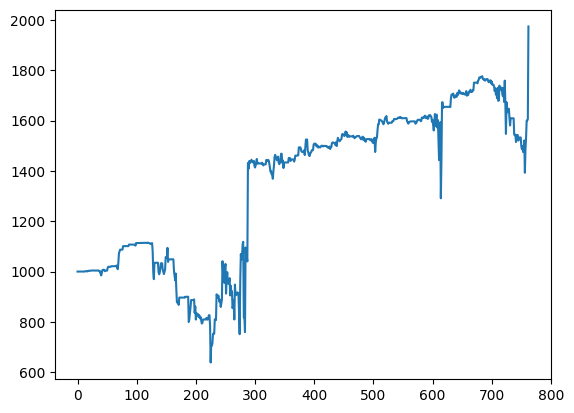

In [44]:
x, y = get_x_y(rec, "total")
plt.plot(y)
plt.show()

In [37]:
np.argwhere(np.array(y) < 1000)

array([[ 39],
       [ 40],
       [ 41],
       [127],
       [128],
       [129],
       [130],
       [131],
       [132],
       [133],
       [134],
       [135],
       [136],
       [137],
       [138],
       [139],
       [140],
       [141],
       [142],
       [143],
       [144],
       [145],
       [146],
       [147],
       [148],
       [149],
       [150],
       [151],
       [153],
       [154],
       [155],
       [156],
       [157],
       [158],
       [159],
       [160],
       [161],
       [162],
       [163],
       [164],
       [165],
       [166],
       [167],
       [168],
       [169],
       [170],
       [171],
       [172],
       [173],
       [174],
       [175],
       [176],
       [177],
       [178],
       [179],
       [180],
       [181],
       [182],
       [183],
       [184],
       [185],
       [186],
       [187],
       [188],
       [189],
       [190],
       [191],
       [192],
       [193],
       [194],
       [195],
      

In [24]:
x[126:]

[1660891020000,
 1660891080000,
 1660945620000,
 1660953180000,
 1660968000000,
 1661040120000,
 1661041260000,
 1661054400000,
 1661069400000,
 1661140800000,
 1661155200000,
 1661155320000,
 1661155860000,
 1661157000000,
 1661157900000,
 1661215560000,
 1661220720000,
 1661222700000,
 1661232360000,
 1661232720000,
 1661232960000,
 1661234400000,
 1661238000000,
 1661241600000,
 1661248140000,
 1661248800000,
 1661356800000,
 1661385600000,
 1661387400000,
 1661388000000,
 1661391060000,
 1661396400000,
 1661408160000,
 1661414400000,
 1661418000000,
 1661428800000,
 1661486400000,
 1661526000000,
 1661526240000,
 1661526900000,
 1661527440000,
 1661555520000,
 1661555880000,
 1661560140000,
 1661572800000,
 1661576820000,
 1661583600000,
 1661743260000,
 1661744100000,
 1661744700000,
 1661776500000,
 1661776860000,
 1661780040000,
 1661780100000,
 1661781960000,
 1661834160000,
 1661860800000,
 1661904420000,
 1661905680000,
 1661909700000,
 1661947200000,
 1662033600000,
 1662043

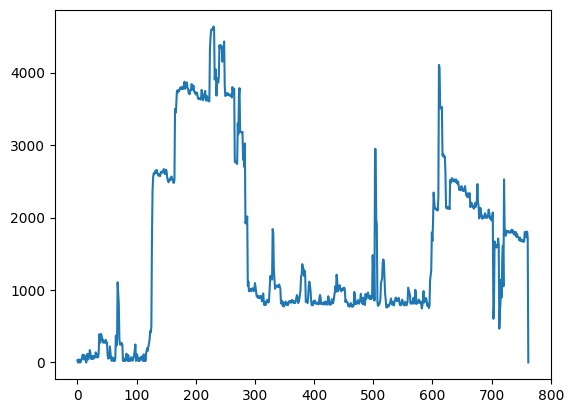

In [17]:
x, y = get_x_y(rec, "calc_value")
plt.plot(y)
plt.show()

In [33]:
eval_df = pd.DataFrame(rec).T
eval_df["price"] = [simp._price_at(t + 60000) for t in eval_df.index]
eval_df

{'exchange': 'bybit', 'market': 'BTC/USDT:USDT', 'timeframe': '1m', 'start': 1670803200000, 'limit': 5, 'end': 1670803500000}


,p_short,qty_short,val_short,p_long,p_lcur,qty_long,val_long,pnl,capital,calc_value,total,price
1659313800000,23365.00,0.001284,30.00,0.0,0.0,0.000000,0.00,0.00,970.00,30.00,1000.00,23351.5
1659326400000,23365.00,0.000000,0.00,0.0,0.0,0.000000,0.00,0.18,1000.18,0.00,1000.18,23374.5
1659335160000,23365.00,0.000000,0.00,23224.0,23224.0,0.001722,40.00,0.18,960.18,40.00,1000.18,23178.5
1659340800000,23365.00,0.000000,0.00,23224.0,23365.0,0.000000,0.00,0.42,1000.42,0.00,1000.42,23323.5
1659486240000,23365.00,0.000000,0.00,22833.0,22833.0,0.001752,40.00,0.42,960.42,40.00,1000.42,22820.5
...,...,...,...,...,...,...,...,...,...,...,...,...
1669161600000,16780.00,0.000000,0.00,15460.5,16520.0,0.005174,85.48,193.43,1113.61,85.48,1199.09,16228.5
1669766400000,16780.00,0.000000,0.00,15460.5,17087.5,0.000000,0.00,201.85,1202.03,0.00,1202.03,16433.5
1669849080000,17223.99,0.004645,80.05,15460.5,17087.5,0.000000,0.00,201.85,1122.03,80.05,1202.08,17182.5
1669849200000,17223.99,0.000000,0.00,15460.5,17087.5,0.000000,0.00,203.52,1203.70,0.00,1203.70,17170.0


In [30]:
eval_shorts = eval_df[["price", "p_short", "qty_short", "val_short"]]
eval_shorts["delta_price"] = eval_shorts["p_short"] - eval_shorts["price"]
eval_shorts["profit"] = eval_shorts["delta_price"] * eval_shorts["qty_short"]
eval_shorts

C:\Users\Lukasz\AppData\Local\Temp\ipykernel_14860\4027933350.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_shorts["delta_price"] = eval_shorts["p_short"] - eval_shorts["price"]
C:\Users\Lukasz\AppData\Local\Temp\ipykernel_14860\4027933350.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_shorts["profit"] = eval_shorts["delta_price"] * eval_shorts["qty_short"]


,price,p_short,qty_short,val_short,delta_price,profit
1659313800000,23343.5,23365.00,0.001284,30.00,21.50,0.027605
1659326400000,23369.5,23365.00,0.000000,0.00,-4.50,-0.000000
1659335160000,23250.5,23365.00,0.000000,0.00,114.50,0.000000
1659340800000,23308.5,23365.00,0.000000,0.00,56.50,0.000000
1659486240000,22878.0,23365.00,0.000000,0.00,487.00,0.000000
...,...,...,...,...,...,...
1669161600000,16218.5,16780.00,0.000000,0.00,561.50,0.000000
1669766400000,16427.0,16780.00,0.000000,0.00,353.00,0.000000
1669849080000,17105.0,17223.99,0.004645,80.05,118.99,0.552671
1669849200000,17132.5,17223.99,0.000000,0.00,91.49,0.000000


In [12]:
from Backtester.streamer.simple import SimpleStreamer

simp = SimpleStreamer("bybit", "BTC/USDT:USDT")

def get_prices_at(streamer: SimpleStreamer, tms: list):
    return [streamer._price_at(t) for t in tms]


In [34]:
eval_longs = eval_df[["price","p_lcur", "p_long", "qty_long", "val_long"]]
eval_longs["delta_price"] = eval_longs["price"] - eval_longs["p_long"]
eval_longs["profit"] = eval_longs["delta_price"] * eval_longs["qty_long"]
eval_longs

C:\Users\Lukasz\AppData\Local\Temp\ipykernel_14860\2780500163.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_longs["delta_price"] = eval_longs["price"] - eval_longs["p_long"]
C:\Users\Lukasz\AppData\Local\Temp\ipykernel_14860\2780500163.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_longs["profit"] = eval_longs["delta_price"] * eval_longs["qty_long"]


,price,p_lcur,p_long,qty_long,val_long,delta_price,profit
1659313800000,23351.5,0.0,0.0,0.000000,0.00,23351.5,0.000000
1659326400000,23374.5,0.0,0.0,0.000000,0.00,23374.5,0.000000
1659335160000,23178.5,23224.0,23224.0,0.001722,40.00,-45.5,-0.078367
1659340800000,23323.5,23365.0,23224.0,0.000000,0.00,99.5,0.000000
1659486240000,22820.5,22833.0,22833.0,0.001752,40.00,-12.5,-0.021898
...,...,...,...,...,...,...,...
1669161600000,16228.5,16520.0,15460.5,0.005174,85.48,768.0,3.973998
1669766400000,16433.5,17087.5,15460.5,0.000000,0.00,973.0,0.000000
1669849080000,17182.5,17087.5,15460.5,0.000000,0.00,1722.0,0.000000
1669849200000,17170.0,17087.5,15460.5,0.000000,0.00,1709.5,0.000000


In [42]:
opening = 1660743660000
closing = 1662695760000

(closing - opening) / 600000 / 60

54.225

In [56]:
elong = eval_longs[eval_longs.index >= opening]
seq = elong[elong.index <= closing]
seq.index = pd.to_datetime(seq.index, unit="ms")

In [57]:
seq

,price,p_lcur,p_long,qty_long,val_long,delta_price,profit
2022-08-17 13:41:00,23490.0,23463.5,23463.50,0.004262,100.00,26.50,0.112941
2022-08-17 13:47:00,23388.5,23398.0,23444.75,0.005971,139.72,-56.25,-0.335896
2022-08-17 20:03:00,23196.0,23200.0,23389.91,0.007696,178.54,-193.91,-1.492259
2022-08-18 00:00:00,23343.0,23463.5,23389.91,0.005971,140.11,-46.91,-0.280122
2022-08-18 23:22:00,23132.0,23145.5,23315.63,0.008564,198.21,-183.63,-1.572567
...,...,...,...,...,...,...,...
2022-09-08 04:57:00,19350.5,19370.0,20770.08,0.236302,4577.16,-1419.58,-335.449174
2022-09-08 07:00:00,19235.5,19370.0,20770.08,0.236302,4577.16,-1534.58,-362.623870
2022-09-09 00:00:00,19303.5,19631.0,20770.08,0.197371,3874.58,-1466.58,-289.459935
2022-09-09 03:25:00,19660.0,19631.0,20770.08,0.197371,3874.58,-1110.08,-219.097277


In [63]:
rec_tx = {pd.to_datetime(k, unit="ms"): v["buy"] for k, v in tx_sorted.items() if k >= opening and k <= closing}

In [64]:
len(rec_tx)

119

In [65]:
rec_tx

{Timestamp('2022-08-17 13:41:00'): [(23463.5, 40, 0.001704775502376031),
  (23463.5, 60, 0.0025571632535640464)],
 Timestamp('2022-08-17 13:47:00'): [(23398.0, 40, 0.0017095478246003932)],
 Timestamp('2022-08-17 20:03:00'): [(23200.0, 40, 0.0017241379310344827)],
 Timestamp('2022-08-18 00:00:00'): [(23463.5, 40, -0.0017241379310344827)],
 Timestamp('2022-08-18 23:22:00'): [(23145.5, 60, 0.0025922965587263183)],
 Timestamp('2022-08-19 00:09:00'): [(23100.0, 40, 0.0017316017316017316)],
 Timestamp('2022-08-19 00:11:00'): [(23023.0, 60, 0.0026060895626113015)],
 Timestamp('2022-08-19 01:29:00'): [(22743.5, 120, 0.005276232769802361)],
 Timestamp('2022-08-19 04:00:00'): [],
 Timestamp('2022-08-19 06:31:00'): [(22679.5, 80, 0.0035274146255428913)],
 Timestamp('2022-08-19 06:37:00'): [(22350.0, 40, 0.0017897091722595079),
  (22350.0, 120, 0.005369127516778523),
  (22521.0, 80, 0.003552240131432885),
  (22350.0, 120, 0.005369127516778523),
  (22350.0, 160, 0.0071588366890380315),
  (22458.5, 

In [13]:
from Backtester.streamer.simple import SimpleStreamer
import numpy as np



class AggStreamer:
    """Interface for SimpleStreamer to Aggregate Candles to list for plotting"""

    STREAM = SimpleStreamer("bybit", "BTC/USDT:USDT")

    def get_prices(self, start, end, key=4) -> list:
        meta, data = self.STREAM.get(start=start, end=end)
        return np.array(data)[:, key]

astream = AggStreamer()

In [14]:
prices = astream.get_prices(1660743660000, 1662695760000)

{'exchange': 'bybit', 'market': 'BTC/USDT:USDT', 'timeframe': '1m', 'start': 1660743660000, 'end': 1662695760000, 'limit': 32535}


In [15]:
prices

array([23490. , 23507. , 23467. , ..., 19823.5, 19837.5, 19893. ])

In [12]:
prices

[1660743900000, 23477.0, 23477.0, 23400.0, 23460.0, 1447.709]

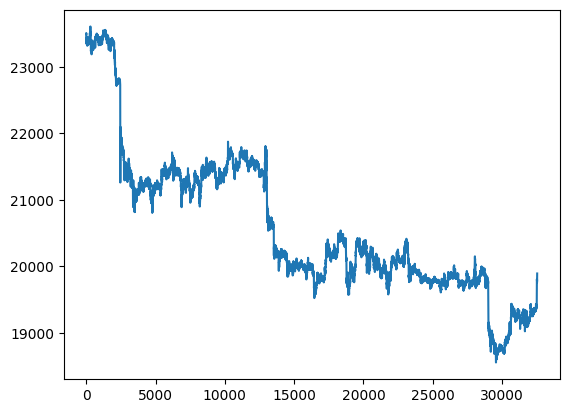

In [16]:
import matplotlib.pyplot as plt

plt.plot(prices)